# <ins>**Explanatory Data Analysis and Multiple Linear Regression Diagnostics**<ins>

We want to learn how to check the assumptions made in a multiple linear regression model.

For that we use so calld regression diagnostics.

But before we can use those regression diagnostics, we have to build the model


## <ins>**Multiple Linear Regression**<ins>

### Installing and Loading Libraries

Before we can begin with multiple linear regression, we need to install necessary libraries. Libraries are loaded as needed for the first time.

First, we update the package installer pip and then install the libraries numpy, pandas, matplotlib, scikit-learn, seaborn, and statsmodels.

In [83]:
%%capture
# Update package installer

!python -m pip install --upgrade pip

# Install libraries

%pip install numpy >nul & pip install pandas >nul & pip install matplotlib >nul & pip install scikit-learn >nul & pip install seaborn >nul & pip install statsmodels >nul & pip install requests >nul

In [84]:
# Reset environment

%reset -f

### Building the Model

We do not want to optimize the model at this point; instead, we want to take a closer look at the diagnostics that need to be examined and interpret the results of the model diagnostics.

First, we need to create the model and load the data.

For this, we use "stem_diameter" as the dependent variable and all other variables as predictors.

In [85]:
import pandas as pd
import statsmodels.api as sm

url = "https://raw.githubusercontent.com/reyar/Statsomat/master/cacao.csv"
df = pd.read_csv(url)

y = df['stem_diameter']
x = df.drop('stem_diameter', axis=1) # axis = 1 to look at columns instead of rows
x = sm.add_constant(x)
model = sm.OLS(y, x).fit() # train the model



## <ins>**Explanatory Data Analysis**<ins>

We have loaded our dataset "cacao.csv". But before using regression diagnostics, we want to get to know our dataset.

For that, we perform a brief explanatory data analysis like descriptive statistics and graphics.

___

### 1. Descriptive Statitics

In [86]:
import seaborn as sns

df_eda = pd.DataFrame(df)
df_eda.describe()

,ant_exclusion,stem_diameter,height,canopy,dw_healthy,dw_infect,dw_total,fw_pulb,fw_seeds,fw_total,ab_fl_op,ab_fl_cl,ab_fl
count,120.000000,120.000000,120.00000,120.000000,120.000000,120.000000,120.00000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000
mean,0.500000,27.096563,293.00000,0.329775,1054.783333,149.550000,1203.52500,16239.708333,5404.450000,21617.558333,1550.133333,3910.916667,5452.608333
std,0.502096,5.305994,34.60555,0.173708,750.210494,146.952622,824.98166,10796.705994,3541.421449,14236.181067,904.836435,2230.832044,3106.131029
min,0.000000,15.737500,223.75000,0.015000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,241.000000,741.000000,1114.000000
25%,0.000000,23.375000,270.37500,0.181250,447.250000,46.750000,573.25000,8083.500000,2824.250000,11107.250000,905.250000,2277.500000,3178.250000
50%,0.500000,26.712500,287.87500,0.344167,939.500000,116.000000,1135.00000,14767.000000,4983.000000,19292.000000,1360.000000,3440.500000,4798.000000
75%,1.000000,30.365625,313.18750,0.449167,1536.000000,216.500000,1717.50000,21869.250000,7544.500000,29008.250000,2018.750000,5053.250000,7006.750000
max,1.000000,46.600000,399.50000,0.708333,3045.000000,920.000000,3500.00000,60787.000000,17025.000000,77812.000000,4369.000000,12469.000000,16501.000000


First we got a table with descriptive statistics, where we can see different information on the variables.

Displayed are:

1. count: Number of non-null entries for each column.

2. mean: Average value of each column.

3. std: Standard deviation of each column.

4. min: Minimum value in each column.

5. 25% (1st Quartile): Value below which 25% of the data falls.

6. 50% (Median/2nd Quartile): Middle value, below which 50% of the data falls.

7. 75% (3rd Quartile): Value below which 75% of the data falls.

8. max: Maximum value in each column.

___

### 2. Histograms

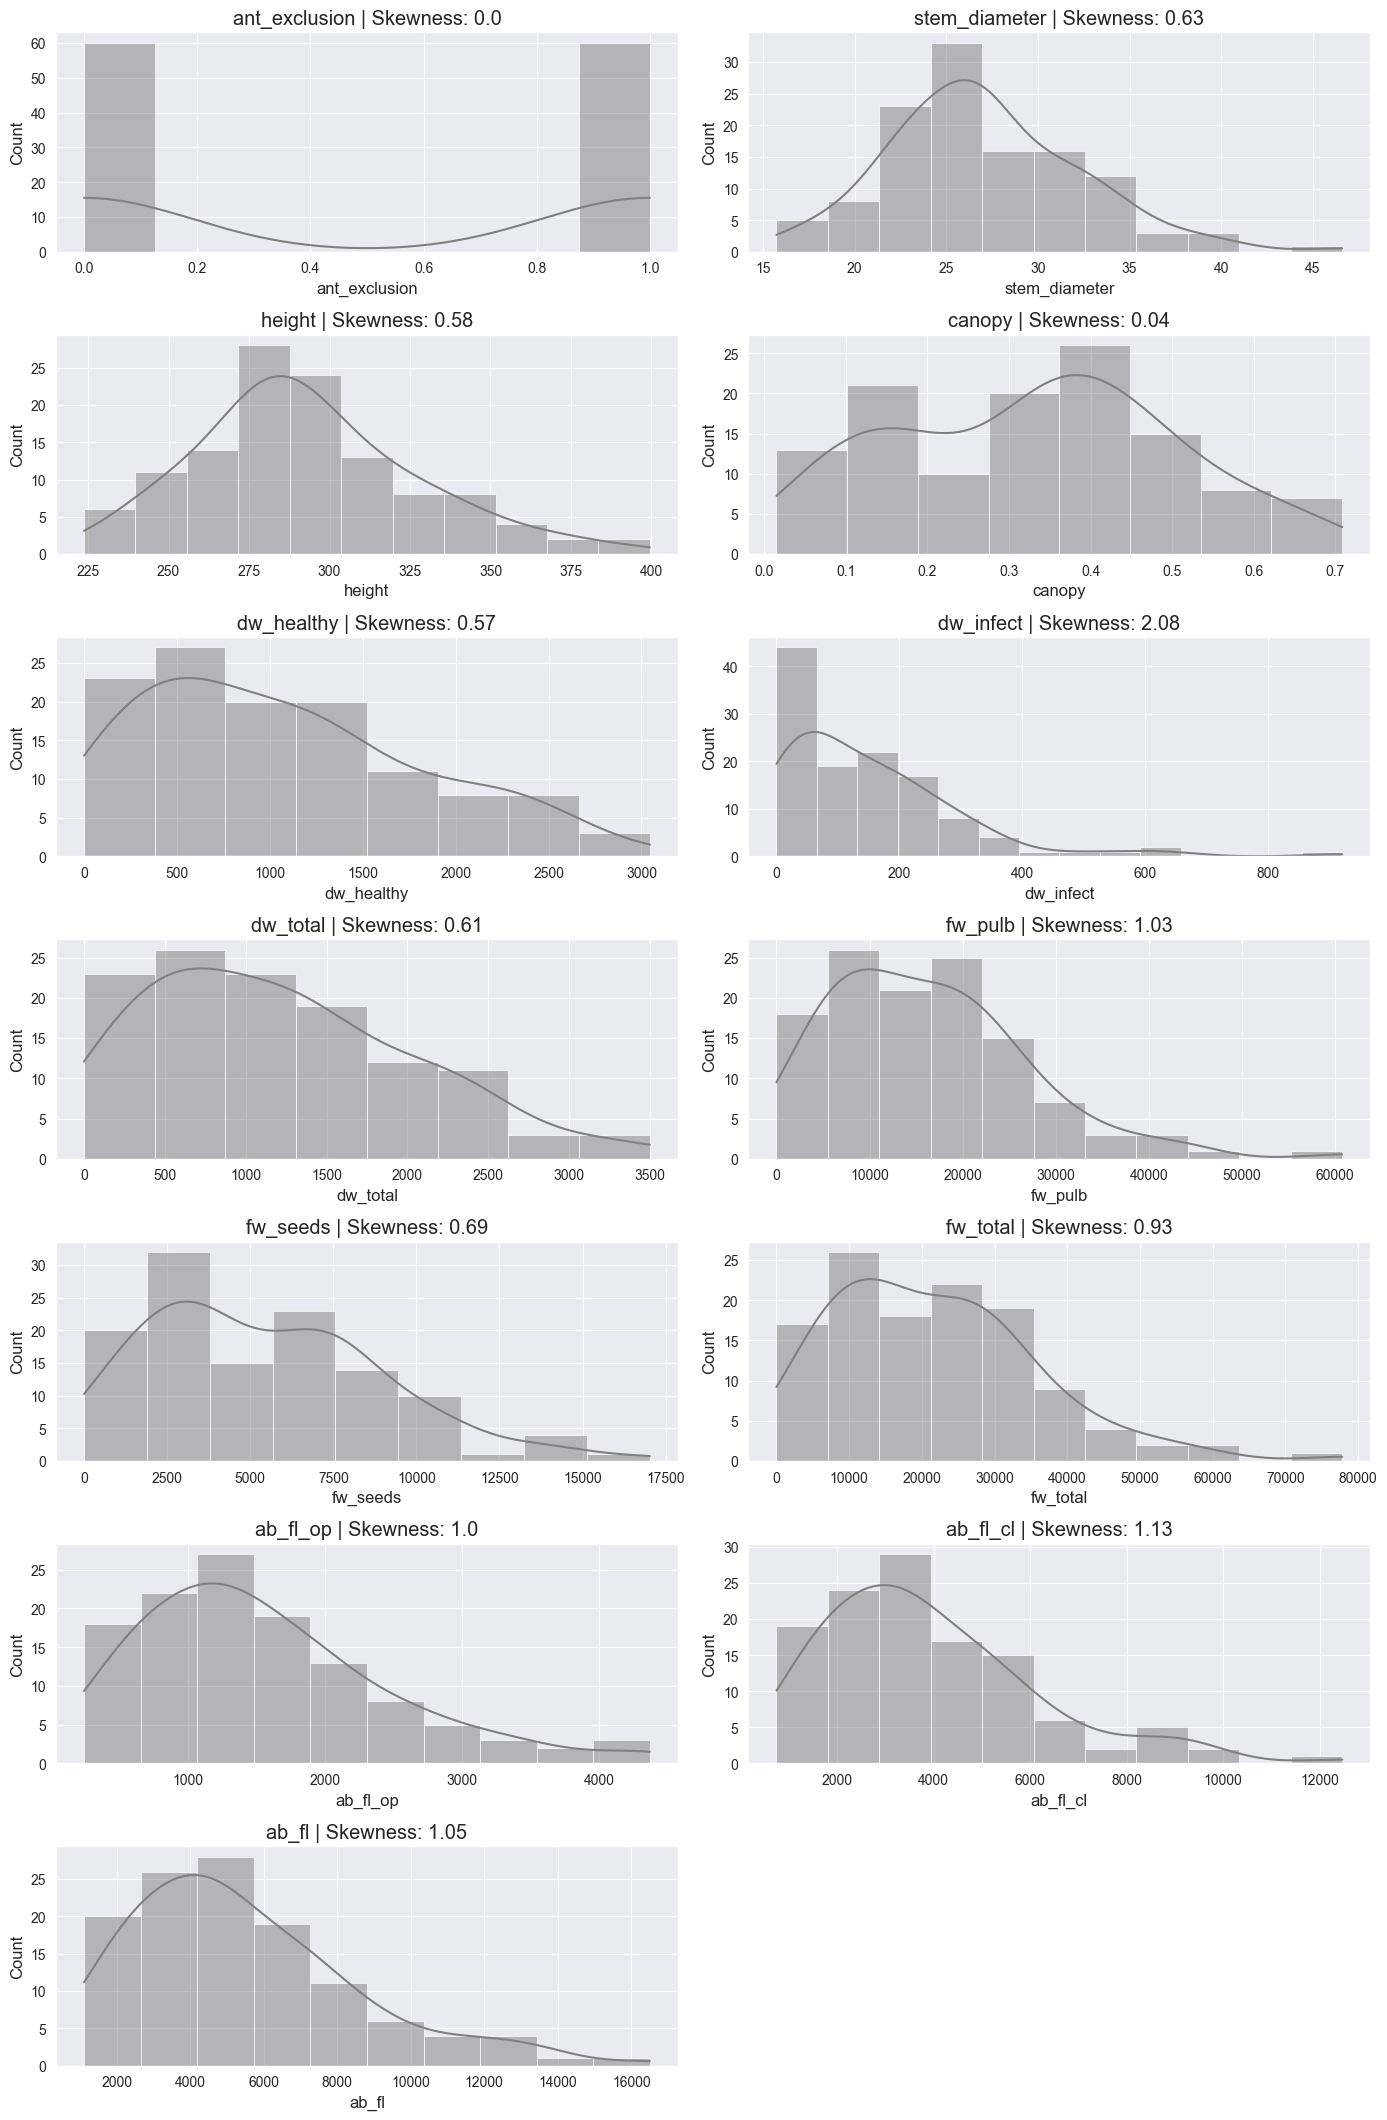

In [87]:
import matplotlib.pyplot as plt

# Set Seaborn style
sns.set_style("darkgrid")

# Plot distribution of each numerical feature
plt.figure(figsize=(14, len(df_eda.columns) * 3))
for idx, feature in enumerate(df_eda.columns, 1):
    plt.subplot(len(df_eda.columns), 2, idx)
    sns.histplot(df[feature], kde=True,color='gray')
    plt.title(f"{feature} | Skewness: {round(df[feature].skew(), 2)}")

# Adjust layout and show plots
plt.tight_layout()
plt.show()

Histograms for each numerical column in the dataset are generated.

Each histogram shows the distribution of values within the respective column.

The x-axis represents the range of values of the numerical data in each column of the data set.

The y-axis represents the frequency (count) of data points that fall within each bin of the x-axis.

The KDE is a non-parametric way to estimate the probability density function of a random variable. 

It smooths out the observed data points into a continuous curve, giving a better understanding of the distribution's shape, central tendency, and variability.

___

## 3. Box-Plots

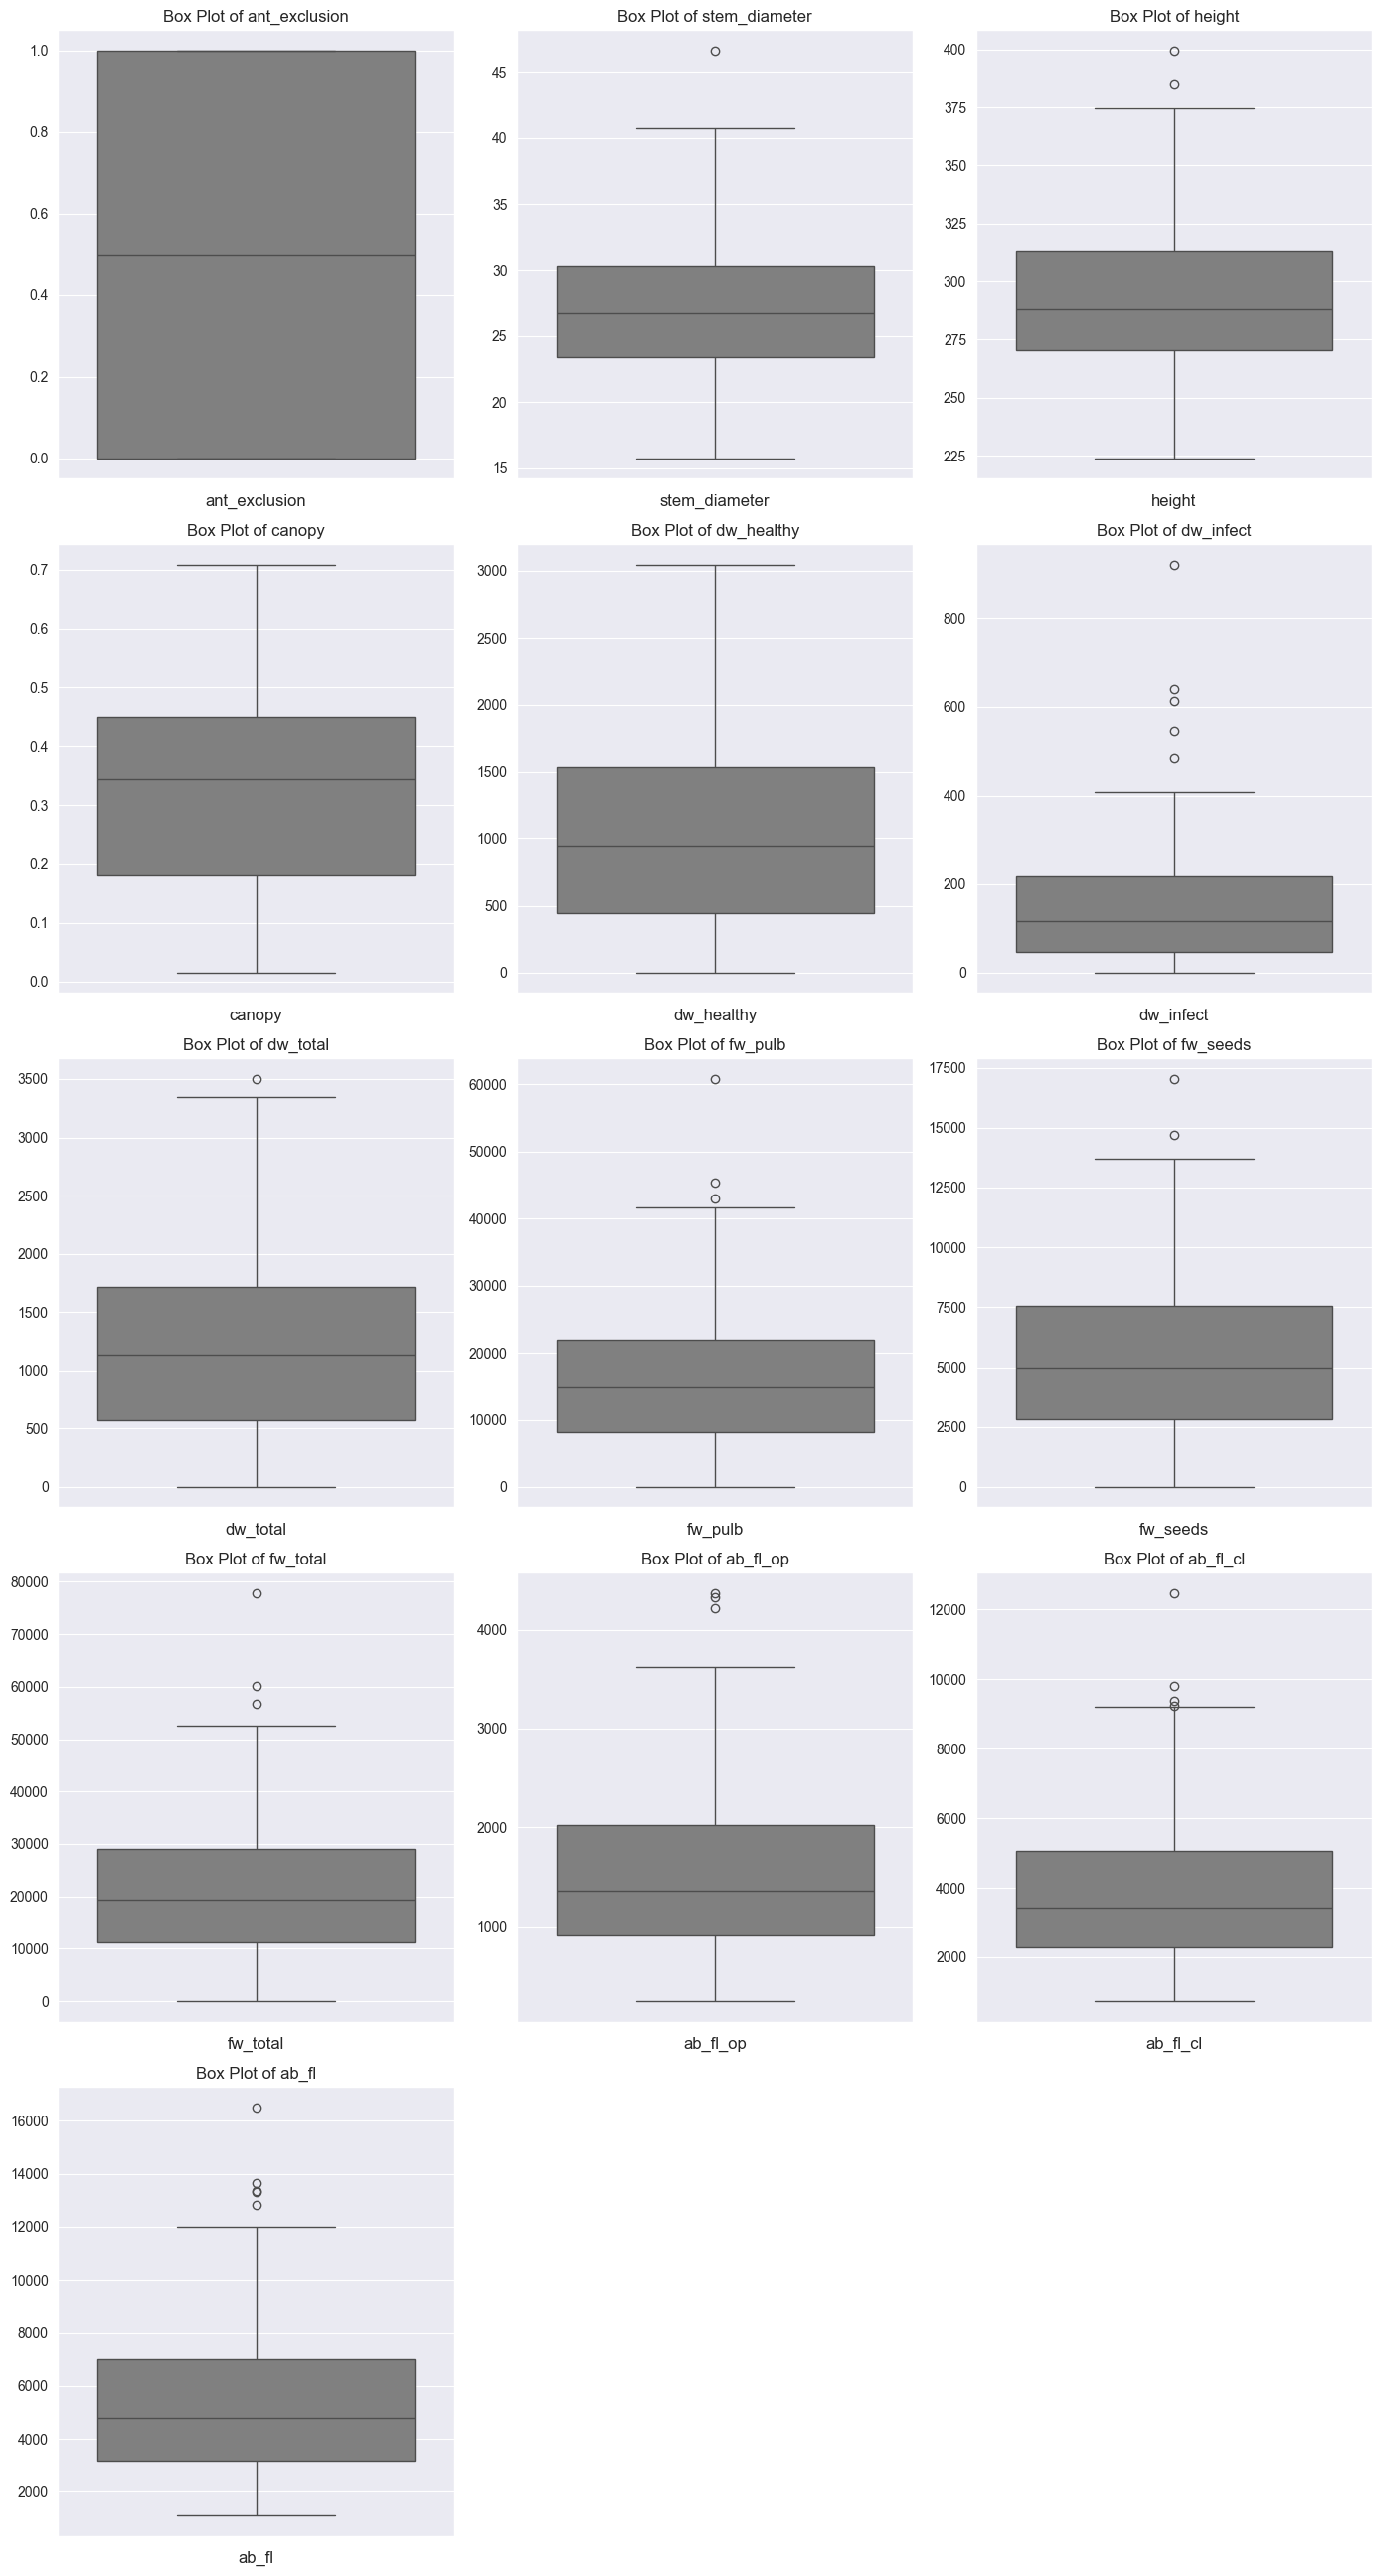

In [88]:
num_cols = 3
num_rows = (len(df_eda.columns) + num_cols - 1) // num_cols

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, len(df_eda.columns) * 2))
axes = axes.flatten()

# Plot each column in a separate subplot
for i, col in enumerate(df.columns):
    sns.boxplot(y=df_eda[col], ax=axes[i], color='gray')
    axes[i].set_title(f'Box Plot of {col}', fontsize=12)
    axes[i].set_xlabel(col, fontsize=12)
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', rotation=0)

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

#plt.suptitle('Box-Plots Summary', fontsize=8)
plt.subplots_adjust(hspace=0.6, wspace=0.6)

plt.tight_layout()
plt.show()


In the boxplots, you can see:

1. Median: The central line in the box.

2. IQR: The range within the box (25th to 75th percentile).

3. Whiskers: Lines extending from the box showing the data range within 1.5 times the IQR.

4. Outliers: Points outside the whiskers.

These elements summarize the distribution, spread, and outliers of each variable.

___

## 3. ECDF-Plots

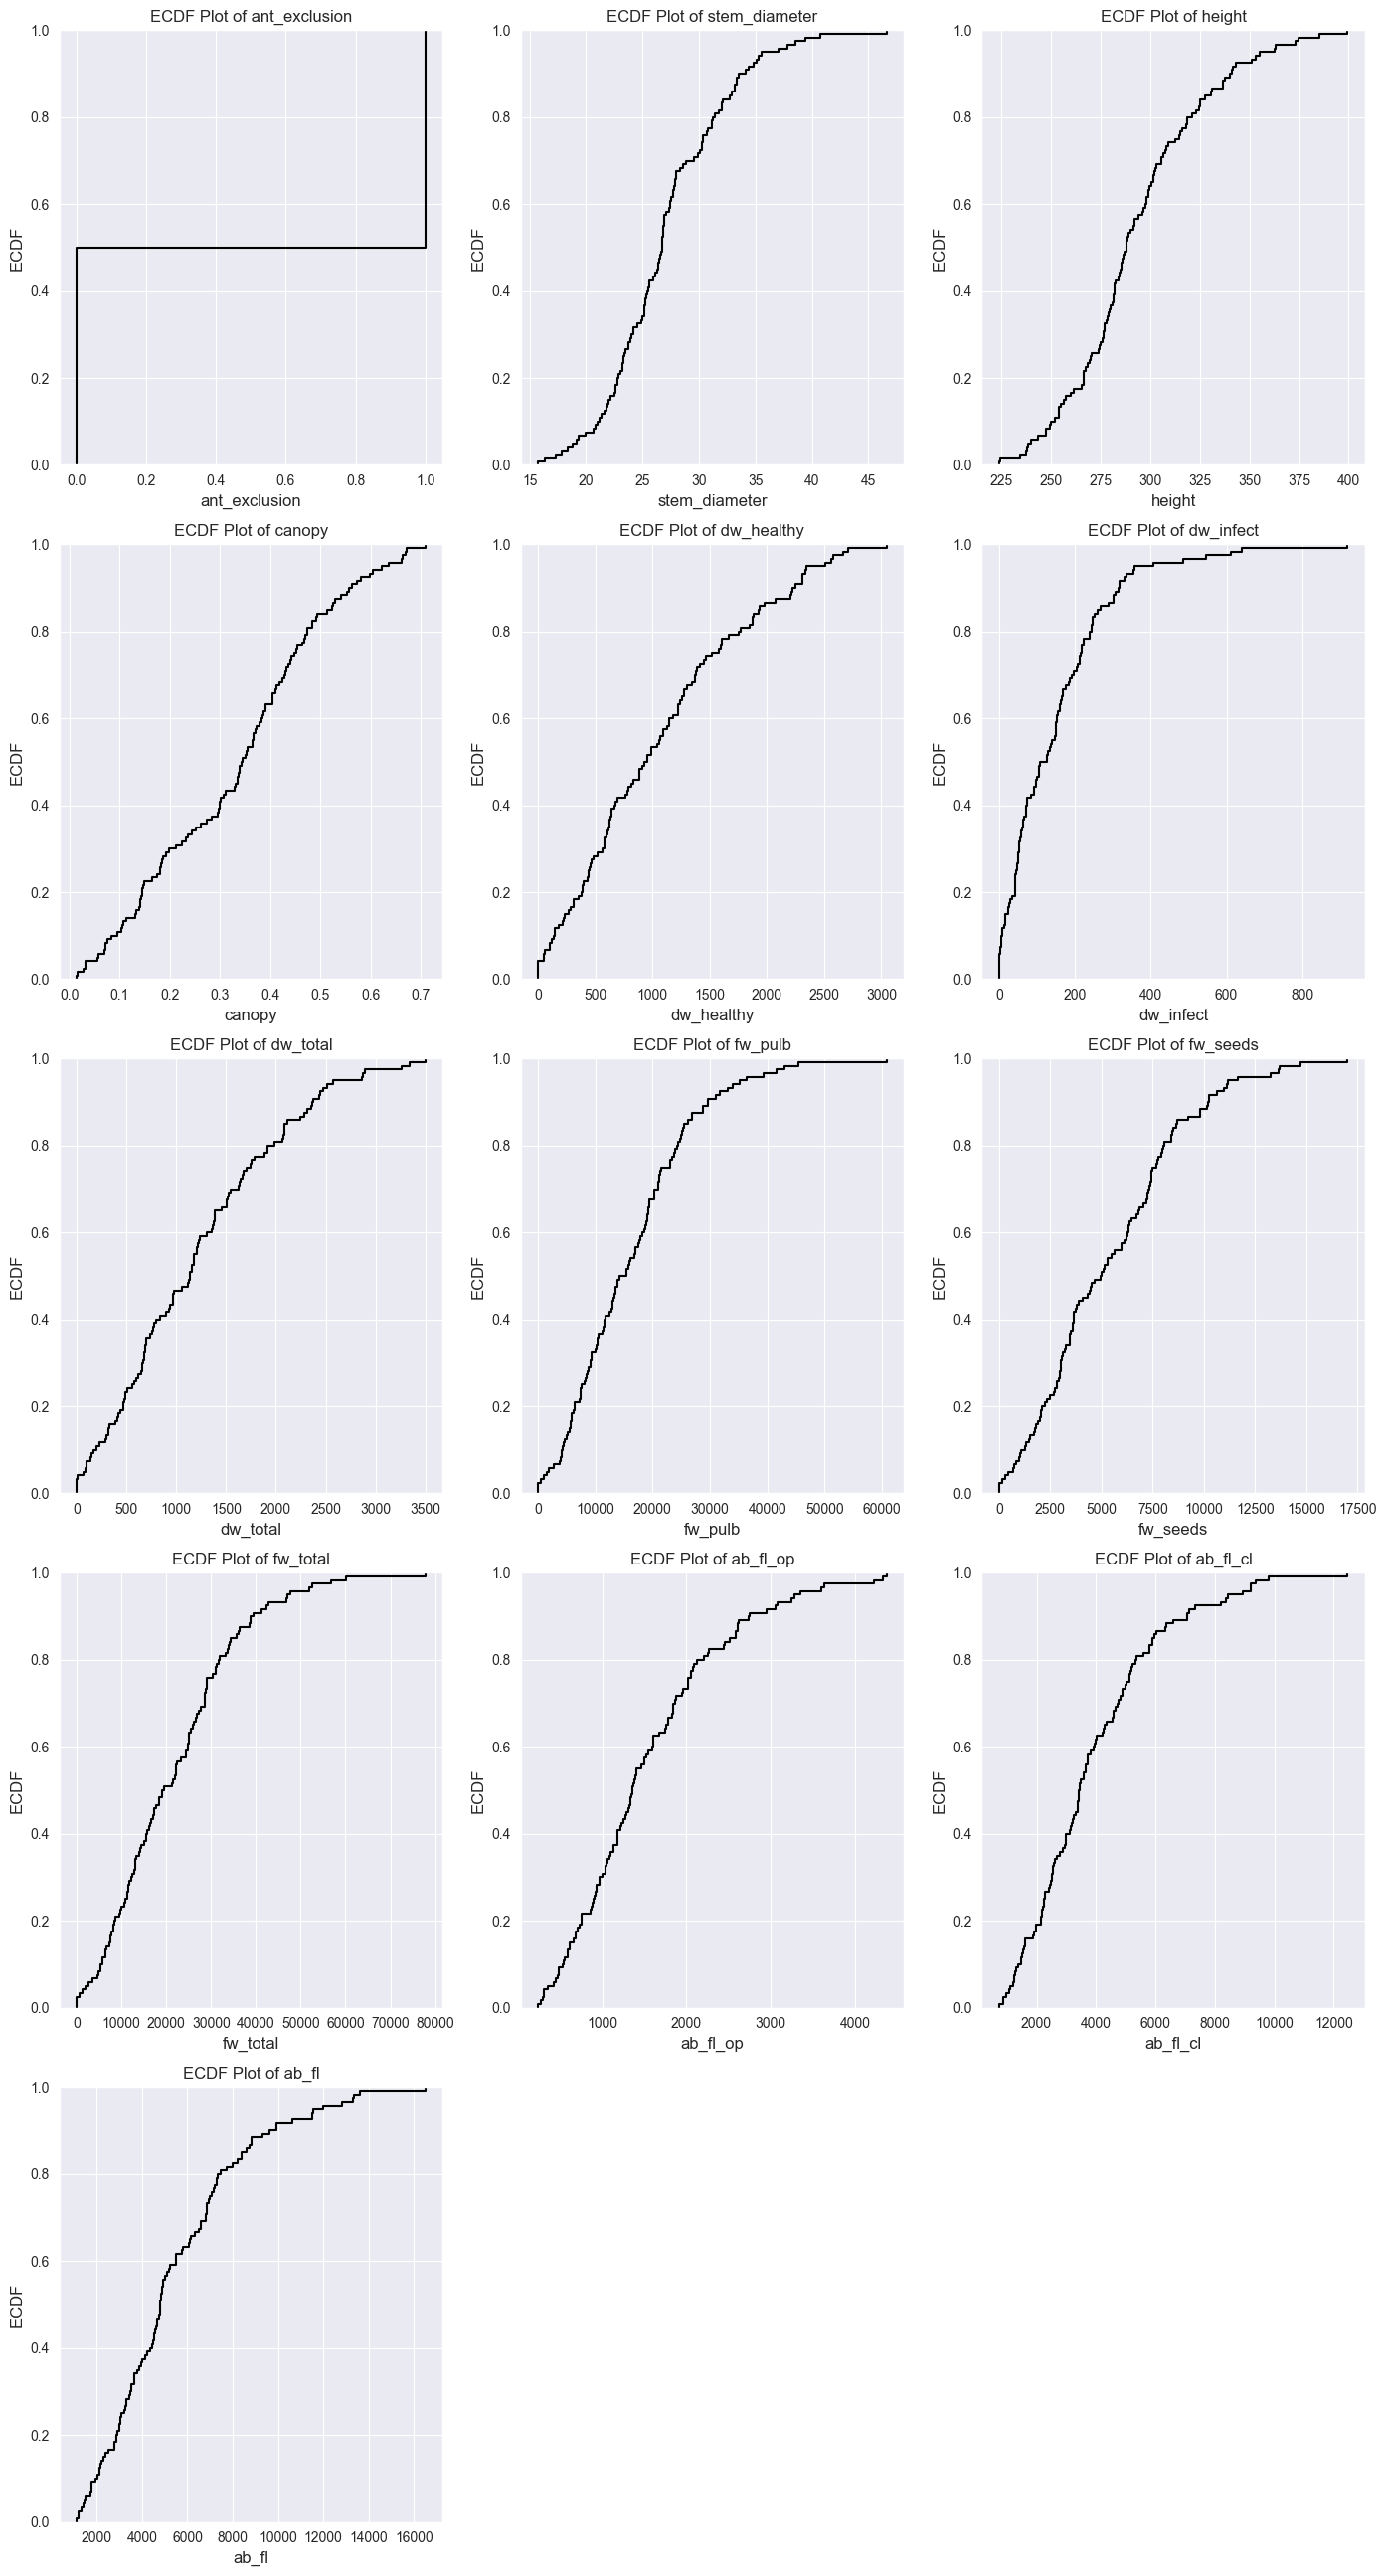

In [89]:
num_cols = 3
num_rows = (len(df_eda.columns) + num_cols - 1) // num_cols

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, len(df_eda.columns) * 2))
axes = axes.flatten()

# Plot each column in a separate subplot
for i, col in enumerate(df_eda.columns):
    sns.ecdfplot(df[col], ax=axes[i], color = "black")
    axes[i].set_title(f'ECDF Plot of {col}', fontsize=12)
    axes[i].set_xlabel(col, fontsize=12)
    axes[i].set_ylabel('ECDF', fontsize=12)
    axes[i].tick_params(axis='x', rotation=0)

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

#plt.suptitle('ECDF Plots Summary', fontsize=8)
plt.subplots_adjust(hspace=0.4, wspace=0.4)

plt.tight_layout()
plt.show()

The x-axis shows the values of the variable.

The y-axis shows the cumulative probability (ECDF).

An ECDF (Empirical Cumulative Distribution Function) plot shows:

1. Cumulative Distribution: How data values accumulate up to 100%.

2. Percentiles: The proportion of data below any given value.

3. Distribution Shape: Insight into data spread and skewness.

4. Comparison: Easy comparison between multiple datasets.

5. Outliers: Detection of outliers through jumps or flat sections.

___

## 4. QQ-Plots

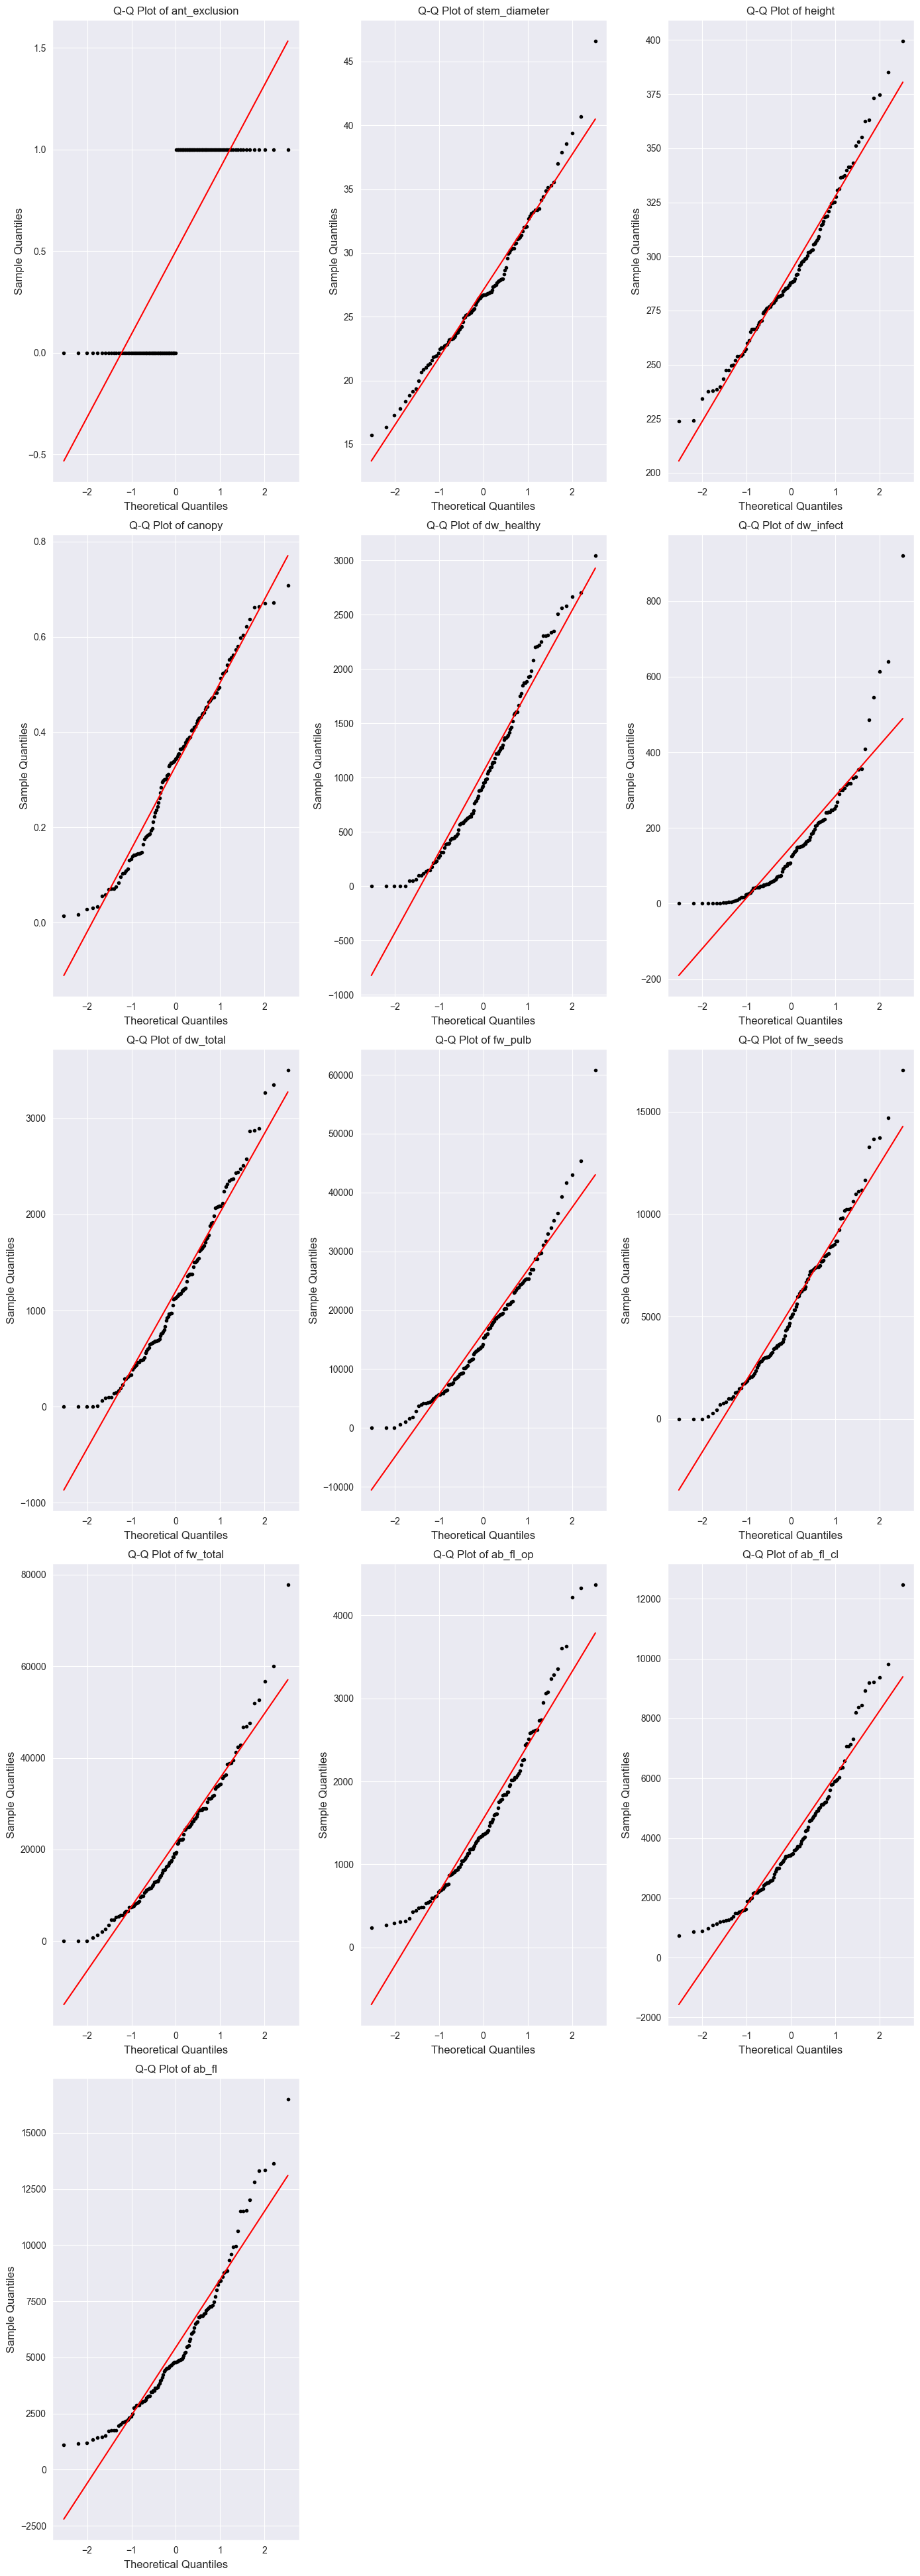

In [90]:
import scipy.stats as stats

num_cols = 3
num_rows = (len(df_eda.columns) + num_cols - 1) // num_cols

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, len(df_eda.columns) * 3))
axes = axes.flatten()

# Plot each column in a separate subplot
for i, col in enumerate(df_eda.columns):
    stats.probplot(df_eda[col], dist="norm", plot=axes[i])
    axes[i].get_lines()[0].set_markersize(3)  # Set marker size to 3
    axes[i].get_lines()[0].set_markerfacecolor('black')  # Set marker color to black
    axes[i].get_lines()[0].set_markeredgecolor('black')  # Set marker edge color to black
    axes[i].set_title(f'Q-Q Plot of {col}', fontsize=12)
    axes[i].set_xlabel('Theoretical Quantiles', fontsize=12)
    axes[i].set_ylabel('Sample Quantiles', fontsize=12)
    axes[i].tick_params(axis='x', rotation=0)

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

#plt.suptitle('Q-Q Plots Summary', fontsize=8)
plt.subplots_adjust(hspace=0.4, wspace=0.4)

plt.tight_layout()
plt.show()

A Q-Q (Quantile-Quantile) plot allows you to compare your data's distribution to a theoretical distribution (usually normal). This theoretical distribution is represented by the red line. Looking at the line formed by the points you can see:

1. Straight Line: Data follows the theoretical distribution.

2. Curved Line: Indicates skewness.

3. Tails Deviations: Suggest heavy or light tails.

4. Outliers: Points far from the line.


## <ins>**Regression Diagnostics**<ins>

The model was developed under certain assumptions. To examine these, we conduct specific diagnostics. These diagnostics ensure that the assumptions of the model have not been violated.

The following aspects are examined:

1. Outliers

2. High-Leverage Points

3. Non-Linearity

4. Heteroscedasticity

5. Correlation of Error Terms

6. Normality of Residuals

7. Collinearity of Predictors

___

### 1. Outliers

Outliers are observations that differ greatly from the expected value of the model. In order to detect outliers studentized residuals can be used.

A rule of thumb for the cut off value is $\pm$ 3, which means that values lower than -3 or bigger than 3 are considered as outliers.

In [91]:
import numpy as np
from statsmodels.stats.outliers_influence import OLSInfluence

influence = OLSInfluence(model)
studentized_residuals = influence.resid_studentized_internal
cutoff_stud_res = 3

print(studentized_residuals[np.abs(studentized_residuals) > cutoff_stud_res])

27    3.148621
dtype: float64


We can see that observation 27 has a absolut studentized residual larger than 3, so we consider it as an outlier. Plotting the studentized residuals can help visualizing this.

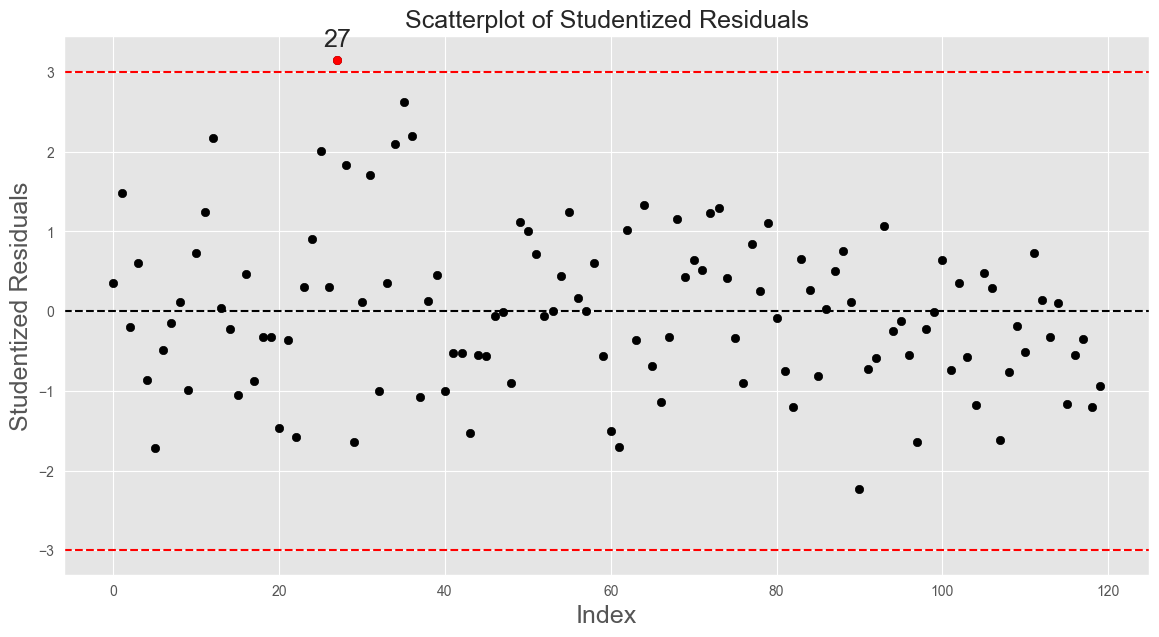

In [92]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize=(14,7))
plt.scatter(range(len(studentized_residuals)), studentized_residuals, color='black')

outliers = np.abs(studentized_residuals) > cutoff_stud_res
plt.scatter( np.arange(len(studentized_residuals))[outliers], studentized_residuals[outliers], color='red')

for i in np.where(outliers)[0]:
    plt.annotate(i, (i, studentized_residuals[i]), textcoords="offset points", xytext=(0,10), ha='center', fontsize = 18)

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=cutoff_stud_res, color='r', linestyle='--')
plt.axhline(y=-cutoff_stud_res, color='r', linestyle='--')

plt.title('Scatterplot of Studentized Residuals', fontsize = 18)
plt.xlabel('Index', fontsize = 18)
plt.ylabel('Studentized Residuals', fontsize = 18)
plt.show()

**Description of the Plot**

The x-axis shows the indeces of the observations, whereas the y-axis shows the value of the studentized residuals of those observations.

The black dashed line shows the zero-line. Therefore, the red dashed lines show the cut off value of $\pm$ 3. 

**Interpretation**

Values outside of this range are marked red. Those values are the outliers. In this data set, datapoint 27 is considered as an outlier.

___

### 2. High-Leverage/-Influence Points

#### 2.1 High-Leverage Points

High-leverage points are observations that have a high influence on the impact regression coefficients and therefore on the model.

In [93]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import OLSInfluence
import matplotlib.pyplot as plt

leverage = influence.hat_matrix_diag
p = x.shape[1] - 1
n = len(y)
threshold_leverage = 2 * (p + 1) / n

high_leverage_points = np.where(leverage > threshold_leverage)[0]
for i in high_leverage_points:
    print(f"Index: {i}, Leverage: {leverage[i]:.4f}")

Index: 20, Leverage: 0.3440
Index: 22, Leverage: 0.2353
Index: 26, Leverage: 0.2542
Index: 30, Leverage: 0.2909
Index: 36, Leverage: 0.2479
Index: 37, Leverage: 0.2489
Index: 42, Leverage: 0.3395
Index: 58, Leverage: 0.2231
Index: 74, Leverage: 0.8342
Index: 76, Leverage: 0.3485
Index: 106, Leverage: 0.6200


We can see that the points 20, 22, 26, 30, 36 , 37, 42, 58, 74, 76 and 106 are considered as high-leverage points. In a plot those results look like this: 

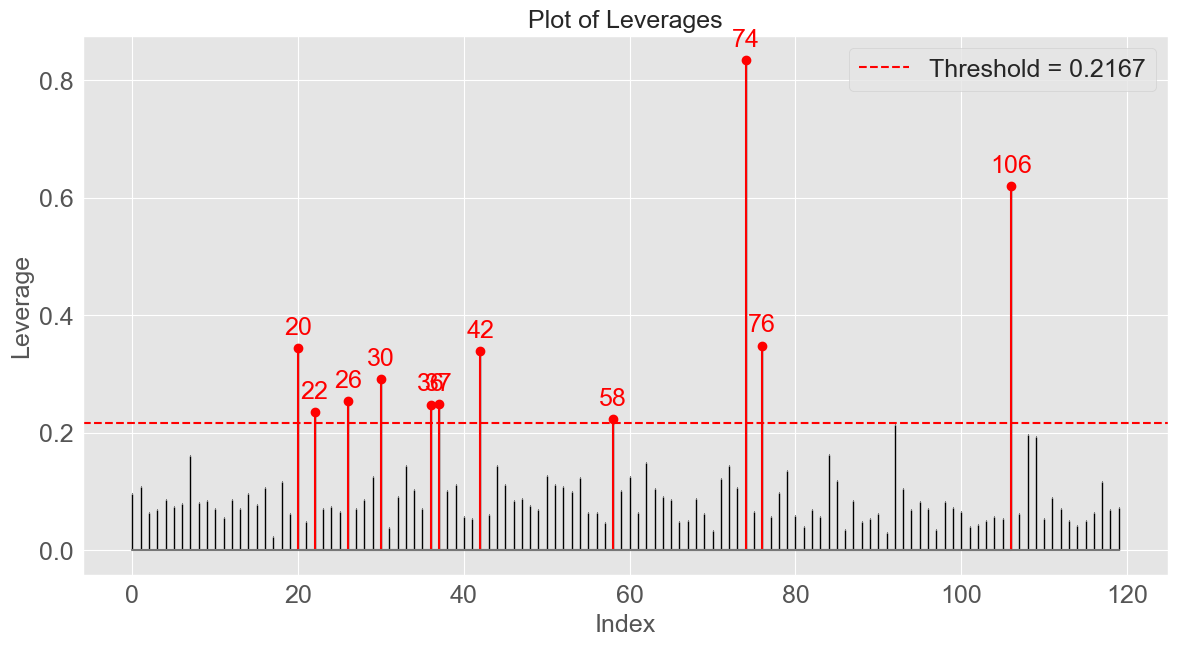

In [94]:
plt.figure(figsize=(14,7))
stemlines, baseline, markerline = plt.stem(np.arange(len(leverage)), leverage, markerfmt=",")
plt.setp(stemlines, 'color', plt.getp(markerline, 'color'))
plt.setp(markerline, markersize=5)
plt.setp(baseline, 'color', 'black', 'linewidth', 1)

for i in high_leverage_points:
    plt.annotate(i, (i, leverage[i]), textcoords="offset points", xytext=(0,10), ha='center', color='red', fontsize = 18)

high_stemlines = plt.stem(high_leverage_points, leverage[high_leverage_points], linefmt='r')
plt.setp(high_stemlines[0], 'color', 'red')

plt.axhline(y=threshold_leverage, color='r', linestyle='--', label=f'Threshold = {threshold_leverage:.4f}')
plt.xlabel('Index', fontsize = 18)
plt.ylabel("Leverage", fontsize = 18)
plt.title("Plot of Leverages", fontsize = 18)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.legend(fontsize = 18)
plt.show()

**Description of the Plot**

The x-axis shows the indeces of the observations, whereas the y-axis shows the value for the leverage of those observations.

The red dashed line shows the threshold. Therefore, values above that line are high-leverage points. 

These points are portrayed as a red line with a red dot at the end. 

Black lines indicate that this observation is not above the cut off value.

#### 2.2 High-Influence Points

In order to diagnose points that have a high influence, we are using Cook's distance. The cut off value for high influence points is $\frac{4}{n}$.

In [95]:
cooks_d = influence.cooks_distance[0]
threshold = 4 / len(y)
high_influence_points = np.where(cooks_d > threshold)[0]
for i in high_influence_points:
    print(f"Index: {i}, Cook's Distance: {leverage[i]:.4f}")

Index: 12, Cook's Distance: 0.0850
Index: 20, Cook's Distance: 0.3440
Index: 22, Cook's Distance: 0.2353
Index: 27, Cook's Distance: 0.0693
Index: 34, Cook's Distance: 0.1033
Index: 35, Cook's Distance: 0.0695
Index: 36, Cook's Distance: 0.2479
Index: 74, Cook's Distance: 0.8342
Index: 76, Cook's Distance: 0.3485


We can see, that the observations 12, 20, 22, 27, 34, 35, 36. 74 and 76 are considered as high influential points.

Now, we want to visualize this result.

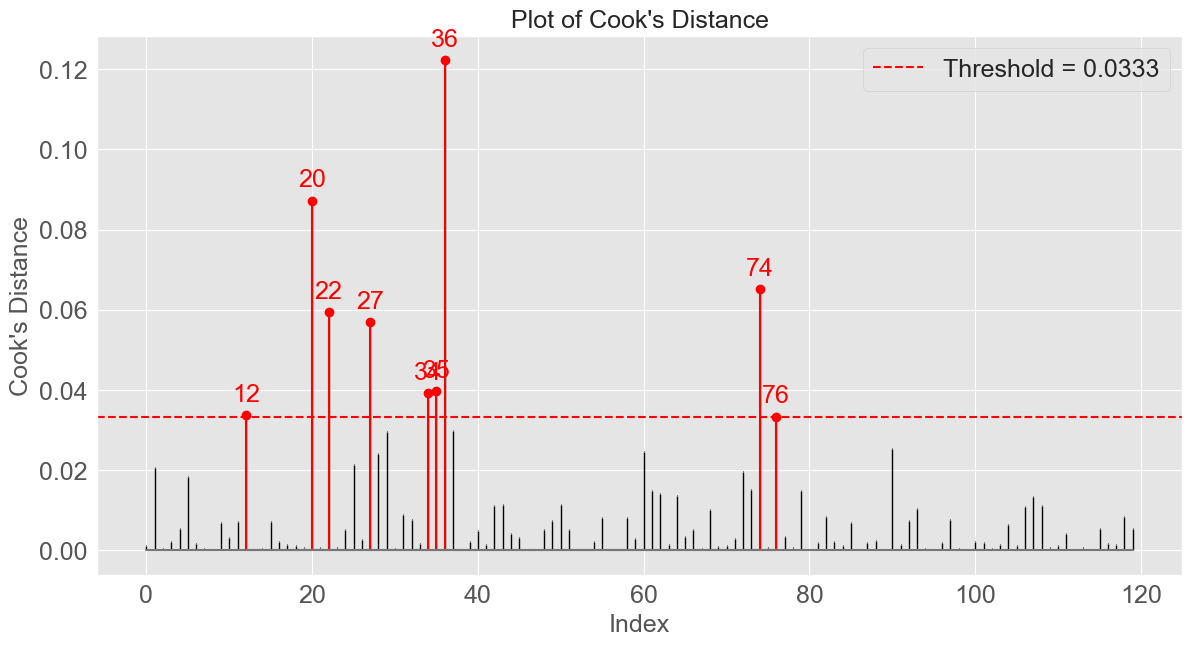

In [96]:
plt.figure(figsize=(14,7))
stemlines, baseline, markerline = plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",")
plt.setp(stemlines, 'color', plt.getp(markerline, 'color'))
plt.setp(markerline, markersize=5)
plt.setp(baseline, 'color', 'black', 'linewidth', 1)

for i in high_influence_points:
    plt.annotate(i, (i, cooks_d[i]), textcoords="offset points", xytext=(0,10), ha='center', color='red',fontsize = 18)

high_stemlines = plt.stem(high_influence_points, cooks_d[high_influence_points], linefmt='r')
plt.setp(high_stemlines[0], 'color', 'red')

plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold = {threshold:.4f}')
plt.xlabel('Index',fontsize = 18)
plt.ylabel("Cook's Distance",fontsize = 18)
plt.title("Plot of Cook's Distance",fontsize = 18)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.legend(fontsize = 18)
plt.show()

**Description of the Plot**

The x-axis shows the indeces of the observations, whereas the y-axis shows the Cook's distance of those observations.

The red dashed line shows the threshold. Therefore, values above that line are high-influential points.

These points are figured as a red line with a red dot at the end. 

Black lines indicate that this observation is not above the cut off value.

In [97]:
intersection_points = np.intersect1d(high_leverage_points, high_influence_points)
print(intersection_points)

[20 22 36 74 76]


**Interpretation**

After identifying points that have a high leverage and a high cook's distance we can conclude the points that have a high influence on the estimations.

Those points are **20, 22, 36, 74** and **76**.

___

### 3. Non-Linearity

One of the assumptions that were made for the multiple linear regression is the assumption of linearity. Now we want to check if the given data violate this assumption.

Linearity means that there is a linear relationship between our dependent variable 'stem_diameter' and the independent variables.

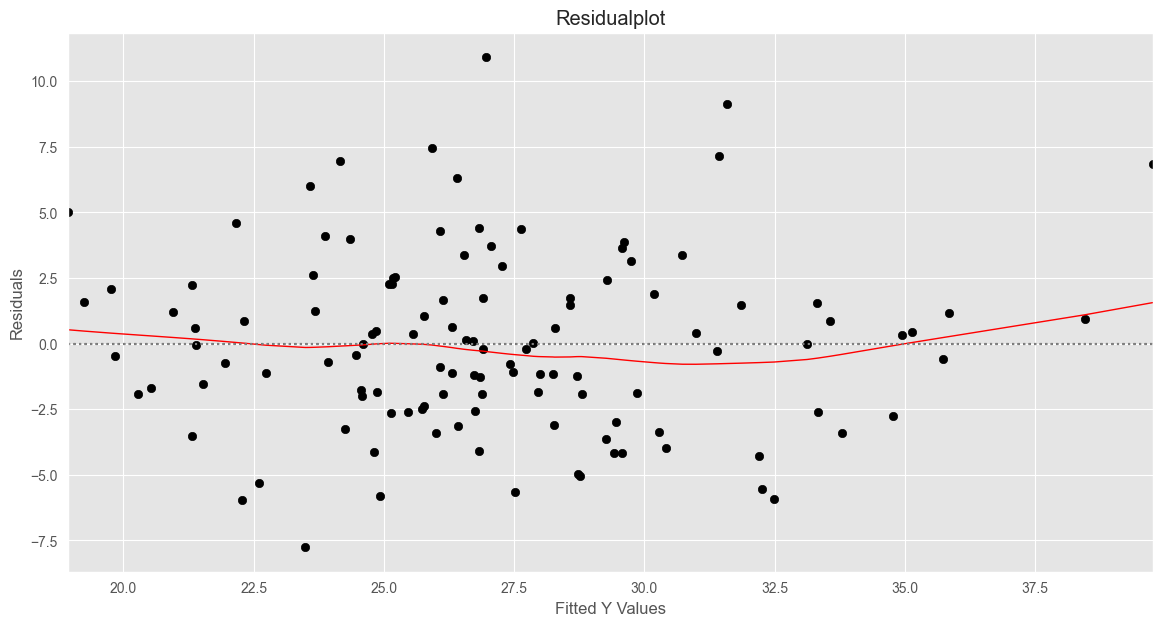

In [98]:
predictions = model.predict(x)
residuals = y - predictions

# Residuenplot erstellen
plt.figure(figsize=(14,7))
sns.residplot(x=predictions, y=residuals, lowess=True, scatter_kws={'s': 0}, line_kws={'color': 'red', 'lw': 1, 'linestyle': '-'})
plt.scatter(predictions, residuals, color='black')
plt.axhline(y=0, color='gray', linestyle=':')
plt.xlabel('Fitted Y Values')
plt.ylabel('Residuals')
plt.title('Residualplot')
plt.show()

**Description of the Plot**

The plot shows the residuals on the y-axis versus the fitted values from the model on the x-axis.

The dotted gray line represents the zero residuals line. Points near the line indicate that the prediction of the model are close to the actual values.

The red line is a smoothed line that visualizes the trend of the residuals.

**Interpretation**

The residuals should be randomly distributed around the zero line if the model is correct. Here, you can see that the residuals are randomly distributed. This can be observed from the red line, as it is always close to the dotted line.

We would say that the linearity assumption is not violated. Now we want to show this in a statistical test. For that we are using the *Rainbow-Test*.

**Rainbow-Test**

This test assesses whether the linearity assumption is violated is the Rainbow Test.

The null hypothesis is that the relationship is linear, so we would suggest that p-values over 0.05 would cause us to reject the null hypothesis.

The 0.05 p-value threshold is a historical convention that provides a practical balance between the risks of Type I and Type II errors for different types of tests (Literature: Regression (Fahrmeir)).

In [99]:
from statsmodels.stats.diagnostic import linear_rainbow

rainbow_test = linear_rainbow(model)
print('Rainbow Test F-statistic: ', rainbow_test[0])
print('Rainbow Test p-value: ', rainbow_test[1])

Rainbow Test F-statistic:  1.2047811890762379
Rainbow Test p-value:  0.2549722679171801


**Interpretation**

As we get 0.25 as a p-value, we cannot reject the null hypothesis. We would suggest that the assumption of linearity is not violated.

___

### 4. Heteroscedasticity

The homoscedasticity is the assumption in the model that the variance of residuals is constant. If this assumption is violated (heteroscedasticity), the standard errors of the coefficients can be biased.

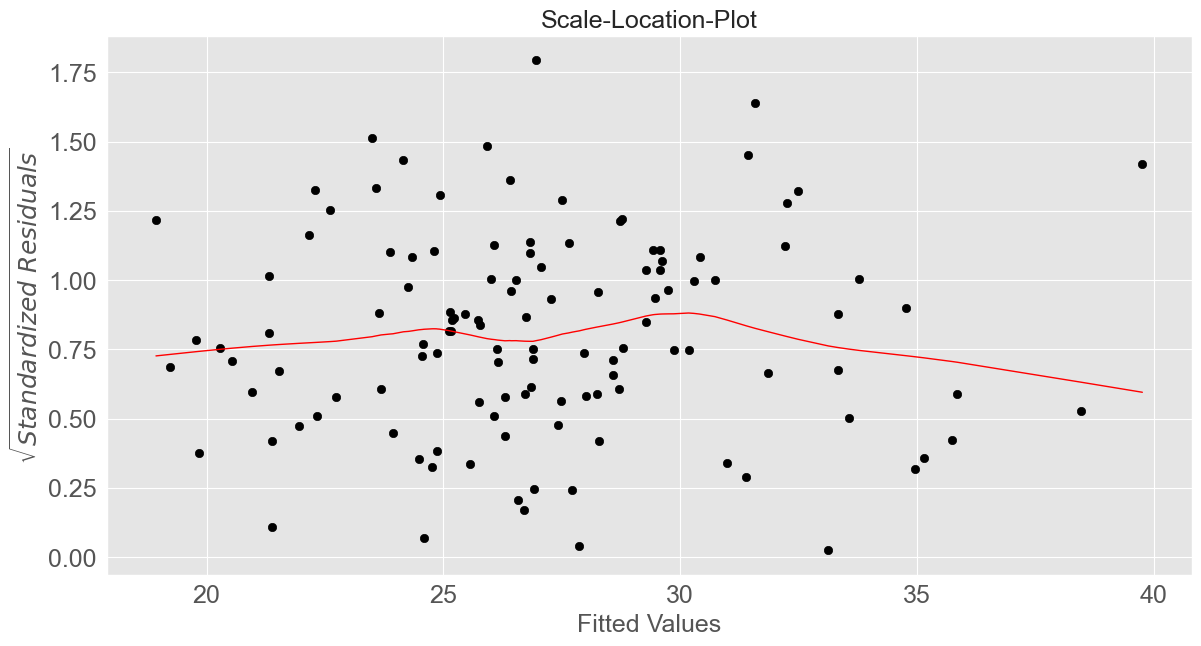

In [100]:
standardized_residuals = residuals / np.std(residuals)

# Wurzel der standardisierten Residuen
sqrt_standardized_residuals = np.sqrt(np.abs(standardized_residuals))

# Plot der Wurzel der standardisierten Residuen gegen die Fitted Values
plt.figure(figsize=(14,7))
sns.regplot(x=predictions, y=sqrt_standardized_residuals, lowess=True, scatter=False,  line_kws={'color': 'red', 'lw': 1, 'linestyle': '-'})
plt.scatter(predictions, sqrt_standardized_residuals, color = 'black')
plt.xlabel('Fitted Values', fontsize = 18)
plt.ylabel('$\sqrt{Standardized \ Residuals}$', fontsize = 18)
plt.title('Scale-Location-Plot', fontsize = 18)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.show()

**Description of the Plot**

The x-axis shows the fitted values from the regression model.

The y-axis shows quare root of the standardized residuals. Standardized residuals are the residuals divided by their estimated standard deviation.

The red line is a smooth line fitted through the points. It helps to visualize any patterns or trends in the spread of the residuals.

**Interpretation**

Ideally, the points should be randomly scattered around the red line, indicating that the residuals have constant variance. 

The points should not follow a certain shape for example like an u-shape or a v-shape.

Here, it seems that the variance of the residuals slightly increases around the fitted values from 25 to 30 which only suggest some degree of heteroscedasticity.

**Breusch-Pangan-Test**

The statistical test for detecting heteroscedasticity is the Breusch-Pangan-Test.

In [44]:
import statsmodels.stats.api as sms

test = sms.het_breuschpagan(residuals, x)
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
bp_test_results = dict(zip(labels, test))

print("Breusch-Pagan-Test Ergebnisse:")
for key, value in bp_test_results.items():
    print(f"{key}: {value}")

Breusch-Pagan-Test Ergebnisse:
Lagrange multiplier statistic: 19.684978894846758
p-value: 0.07328472580462579
f-value: 1.7497319266047593
f p-value: 0.06623880607200823


Using the significance level of 5% the p-value of > 0.05 indicates that the hypothesis of a homoscedastic variance can not be rejected.

We would assume that the assumption of homoscedasticity is not violated.

___

### 5. Correlation of Error Terms

In the linear regression model, the error terms should not be correlated. We can visualize this by this plot:

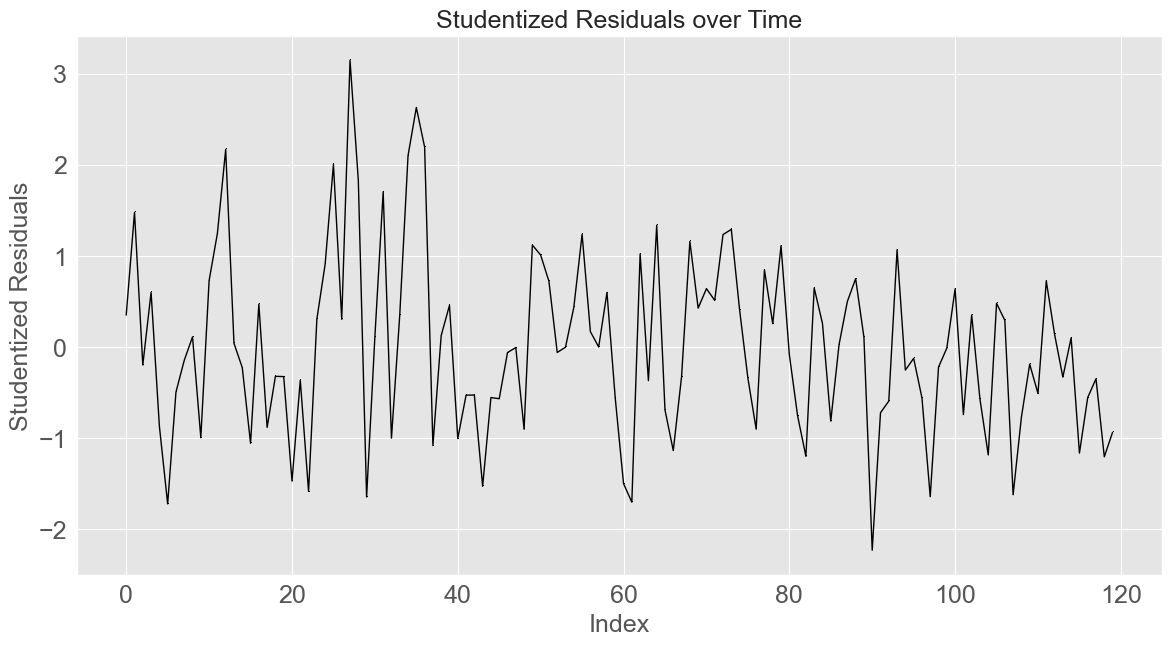

In [101]:
plt.figure(figsize=(14,7))
plt.plot(studentized_residuals, marker=',', linestyle='-', color='black', linewidth=1)
plt.xlabel('Index', fontsize = 18)
plt.ylabel('Studentized Residuals', fontsize = 18)
plt.title('Studentized Residuals over Time', fontsize = 18)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.show()

**Description of the Plot**

This plot shows the studentized residuals of the plot (y-axis) and their indeces (x-axis). 

If the residuals appear to be randomly scattered around the zero line, it suggests that the residuals are independent.

**Interpretation**

This plot shows a slightly decreasing pattern, which is why we would suggest that the error terms are correlated.

We want to show it now with the Durbin-Watson Test.

**Durbin-Watson-Test**

In [46]:
from statsmodels.stats.stattools import durbin_watson

durbin_watson(model.resid)

1.4407171708561604

As we can see the value 1.44 is out of the recommended range of 1.5 - 2.5, so we would suggest that the error terms are correlated.

___

### 6. Normality of Residuals

The next assumption that we want to check is the assumption of normality of residuals. We can check this by using the QQ-Plot.

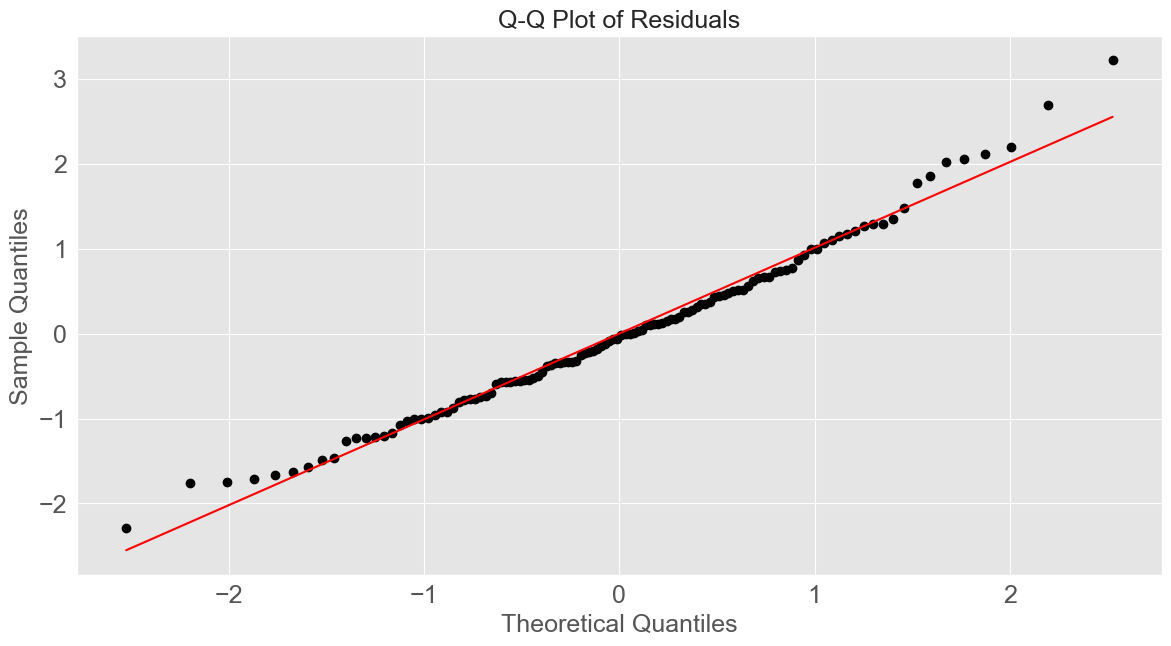

In [102]:
import scipy.stats as stats

plt.figure(figsize=(14,7))
stats.probplot(standardized_residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals',  fontsize = 18)
plt.xlabel('Theoretical Quantiles', fontsize = 18)
plt.ylabel('Sample Quantiles', fontsize = 18)
plt.tick_params(axis='both', which='major', labelsize=18)

plt.gca().get_lines()[0].set_markerfacecolor('black')
plt.gca().get_lines()[0].set_markeredgecolor('black')

plt.show()

**Description of the Plot**

The x-axis represents the theoretical quantiles of the normal distribution.

The y-axis shows the observed quantile from the data.

If the normality assumption is not violated the datapoints should be aligned at the bisector, which is the red line in the plot.

**Interpretation**

Most points lie close to the red line, but looking at the the beginning and the end of the red line, the points deviate as a tail from the red line.

We would say, that the assumption of normal distribution might be violated.

**Shapiro-Wilk-Test**

A statistical test that can be used to watch out for normality distribution is the Shapiro Wilk Test.

In [48]:
from scipy.stats import shapiro
test_stat, p_value = shapiro(model.resid)

print(f'Shapiro test statistic: {test_stat}')
print(f'Shapiro test p-value: {p_value}')

Shapiro test statistic: 0.9848445057868958
Shapiro test p-value: 0.1989554911851883


As we can see, the p-value is higher than 0.05 so we would not reject the null hypothesis that the residuals are normal distributed.

___

### 7. Collinearity of Predictors

The Variance Inflation Factor (VIF) is a measurement used to detect multicollinearity in a regression analysis. 

High VIF values, which means values greater than 10, indicate high multicollinearity between the independent variables.

In [49]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["Feature"] = df.columns
vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
vif_data = vif_data[vif_data["Feature"] != "const"]
high_vif = vif_data[vif_data["VIF"] > 10]

print(vif_data[vif_data["VIF"] > 10].sort_values(by="VIF", ascending=False))

          Feature           VIF
9        fw_total  33774.688020
6        dw_total  22085.398286
7         fw_pulb  18933.478260
4      dw_healthy  17486.051055
12          ab_fl   9626.831568
11       ab_fl_cl   4830.907602
8        fw_seeds   2184.446944
10       ab_fl_op    980.937538
5       dw_infect    453.351914
2          height     66.933186
1   stem_diameter     65.105757


Those variables have a VIF greater than 10, which indicates severe multicollinearity.

These variables are likely highly correlated with other variables in the model.

Now we are using a covariance matrix to visualize relationships between variables graphically.

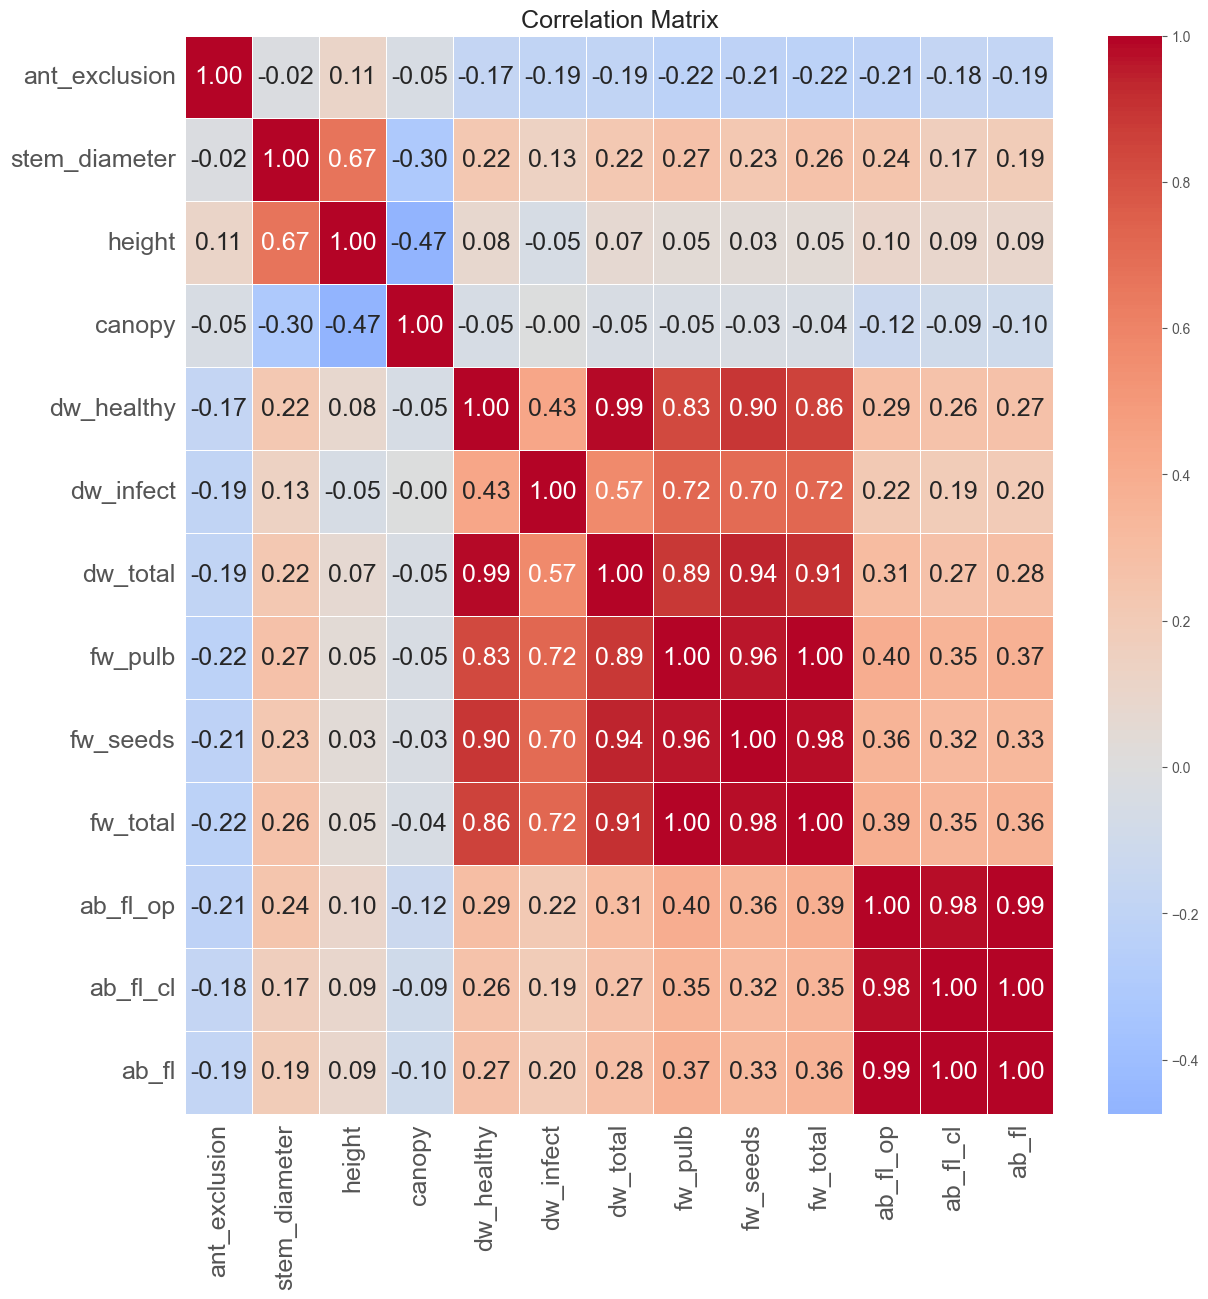

In [108]:
corr_matrix = df.corr()

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(14,14))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, center = 0,annot_kws={"size": 18})
plt.title('Correlation Matrix', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

**Description of the Plot**

The x-axis and y-axis both list the same set of variables, showing pairwise correlations between these variables.

The heatmap uses a color gradient from blue to red.

Red represents a high positive correlation (close to 1).

Blue represents a high negative correlation (close to -1).

The diagonal cells (correlation of a variable with itself) have a correlation coefficient of 1, indicated by dark red.

**Intepretation**

By looking at the VIF and the correlation matrix we can identify the variables that have a high correlation.

For example fw_total has a very high VIF (33774) and is highly correlated with dw_healty, dw_inflect, fw_pulb and fw_seeds.

But the correlation with other variables like ab_fl_op, ab_fl_cl or ab_fl is relativly high (greater than 0.3) which is the reason for this VIF.